In [49]:
# importar paquetes a ocupar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret

In [50]:
# importar archivos csv
crossBattlelog = pd.read_csv('datasets/teams/battlelog_teams.csv', index_col=0)
crossBattlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48405 entries, 0 to 48404
Data columns (total 63 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   battleTime                             48405 non-null  object 
 1   playertag                              48405 non-null  object 
 2   event.id                               48405 non-null  int64  
 3   event.mode                             45288 non-null  object 
 4   event.map                              48019 non-null  object 
 5   battle.mode                            48405 non-null  object 
 6   battle.type                            48405 non-null  object 
 7   battle.result                          48405 non-null  object 
 8   battle.duration                        48405 non-null  float64
 9   battle.trophyChange                    32500 non-null  float64
 10  battle.starPlayer.tag                  40850 non-null  object 
 11  ba

In [51]:
# importar archivos csv
players = pd.read_csv('datasets/players/players.csv', index_col=0)
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76928 entries, 0 to 76927
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tag                                   76928 non-null  object 
 1   name                                  76927 non-null  object 
 2   nameColor                             74794 non-null  object 
 3   trophies                              76928 non-null  int64  
 4   highestTrophies                       76928 non-null  int64  
 5   highestPowerPlayPoints                56236 non-null  float64
 6   expLevel                              76928 non-null  int64  
 7   expPoints                             76928 non-null  int64  
 8   isQualifiedFromChampionshipChallenge  76928 non-null  bool   
 9   3vs3Victories                         76928 non-null  int64  
 10  soloVictories                         76928 non-null  int64  
 11  duoVictories   

In [52]:
# importar archivos csv
brawlers = pd.read_csv('datasets/brawlers/brawlers_stats.csv', index_col=0)
brawlers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      64 non-null     int64 
 1   name    64 non-null     object
 2   role    64 non-null     object
 3   range   64 non-null     object
 4   speed   64 non-null     object
 5   health  64 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 3.5+ KB


In [53]:
# crear columna playerteam
for i in range(len(crossBattlelog)):
	if any(crossBattlelog.loc[i, 'playertag'] == tag for tag in [crossBattlelog.loc[i, 'battle.team1.player1.tag'], crossBattlelog.loc[i, 'battle.team1.player2.tag'], crossBattlelog.loc[i, 'battle.team1.player3.tag']]):
		crossBattlelog.loc[i, 'player_team'] = 'team1'
	elif any(crossBattlelog.loc[i, 'playertag'] == tag for tag in [crossBattlelog.loc[i, 'battle.team2.player1.tag'], crossBattlelog.loc[i, 'battle.team2.player2.tag'], crossBattlelog.loc[i, 'battle.team2.player3.tag']]):
		crossBattlelog.loc[i, 'player_team'] = 'team2'
	else:
		print("error in team assignation for id " + str(i))

crossBattlelog['player_team'].value_counts()

team1    24221
team2    24184
Name: player_team, dtype: int64

In [54]:
# crear columna winner_team
for i in range(len(crossBattlelog)):
	if crossBattlelog.loc[i, 'battle.result'] == 'draw':
		crossBattlelog.loc[i, 'winner_team'] = 'draw'
	elif crossBattlelog.loc[i, 'player_team'] == 'team1' and crossBattlelog.loc[i, 'battle.result'] == 'victory':
		crossBattlelog.loc[i, 'winner_team'] = 'team1'
	elif crossBattlelog.loc[i, 'player_team'] == 'team1' and crossBattlelog.loc[i, 'battle.result'] == 'defeat':
		crossBattlelog.loc[i, 'winner_team'] = 'team2'
	elif crossBattlelog.loc[i, 'player_team'] == 'team2' and crossBattlelog.loc[i, 'battle.result'] == 'victory':
		crossBattlelog.loc[i, 'winner_team'] = 'team2'
	elif crossBattlelog.loc[i, 'player_team'] == 'team2' and crossBattlelog.loc[i, 'battle.result'] == 'defeat':
		crossBattlelog.loc[i, 'winner_team'] = 'team1'
	else:
		print("error in winner assignation for id " + str(i))

crossBattlelog['winner_team'].value_counts()

team1    24295
team2    23893
draw       217
Name: winner_team, dtype: int64

In [58]:
# eliminar draws, no aportan al modelo
crossBattlelog = crossBattlelog[crossBattlelog['winner_team'] != 'draw'].reset_index(drop=True)

In [59]:
# agregar columna identificando batallas levelup y definir subset
for i in range(len(crossBattlelog)):

	t1p1 = crossBattlelog.loc[i, 'battle.team1.player1.brawler.trophies']
	t1p2 = crossBattlelog.loc[i, 'battle.team1.player2.brawler.trophies']
	t1p3 = crossBattlelog.loc[i, 'battle.team1.player3.brawler.trophies']
	t2p1 = crossBattlelog.loc[i, 'battle.team2.player1.brawler.trophies']
	t2p2 = crossBattlelog.loc[i, 'battle.team2.player2.brawler.trophies']
	t2p3 = crossBattlelog.loc[i, 'battle.team2.player3.brawler.trophies']

	if  (t1p1 <= 500 or t1p2 <= 500 or t1p3 <= 500 or t2p1 <= 500 or t2p2 <= 500 or t2p3 <= 500):
		crossBattlelog.loc[i, 'low_trophy'] = 'y'
	else:
		crossBattlelog.loc[i, 'low_trophy'] = 'n'

crossBattlelog = crossBattlelog[crossBattlelog['low_trophy'] == 'n']

crossBattlelog.shape

(30533, 66)

In [60]:
# agregar players
battlelogSet = crossBattlelog

def add_players(df, prefix):
	df = pd.merge(left=df, right=players.add_prefix(prefix), on=prefix + 'tag', how='left', suffixes=('','_p'))
	return df

battlelogSet = add_players(battlelogSet, 'battle.team1.player1.')
battlelogSet = add_players(battlelogSet, 'battle.team1.player2.')
battlelogSet = add_players(battlelogSet, 'battle.team1.player3.')
battlelogSet = add_players(battlelogSet, 'battle.team2.player1.')
battlelogSet = add_players(battlelogSet, 'battle.team2.player2.')
battlelogSet = add_players(battlelogSet, 'battle.team2.player3.')

battlelogSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30533 entries, 0 to 30532
Columns: 168 entries, battleTime to battle.team2.player3.import_date
dtypes: float64(105), int64(1), object(62)
memory usage: 39.4+ MB


In [61]:
# agregar brawler stats
def add_brawlers(df, prefix):
	df = pd.merge(left=df, right=brawlers.add_prefix(prefix), on=prefix + 'id', how='left', suffixes=('','_b'))
	return df

battlelogSet = add_brawlers(battlelogSet, 'battle.team1.player1.brawler.')
battlelogSet = add_brawlers(battlelogSet, 'battle.team1.player2.brawler.')
battlelogSet = add_brawlers(battlelogSet, 'battle.team1.player3.brawler.')
battlelogSet = add_brawlers(battlelogSet, 'battle.team2.player1.brawler.')
battlelogSet = add_brawlers(battlelogSet, 'battle.team2.player2.brawler.')
battlelogSet = add_brawlers(battlelogSet, 'battle.team2.player3.brawler.')

battlelogSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30533 entries, 0 to 30532
Columns: 198 entries, battleTime to battle.team2.player3.brawler.health
dtypes: float64(105), int64(7), object(86)
memory usage: 46.4+ MB


In [62]:
battlelogFinal = battlelogSet[[
	'battleTime'
	,'event.mode'
	,'event.map'
	,'battle.mode'
	,'battle.type'
	,'battle.duration'
	,'battle.trophyChange'
	,'player_team'
	,'winner_team'
	,'battle.team1.player1.brawler.name'
	,'battle.team1.player1.brawler.power'
	,'battle.team1.player1.brawler.trophies'
	,'battle.team1.player1.trophies'
	,'battle.team1.player1.highestTrophies'
	,'battle.team1.player1.highestPowerPlayPoints'
	,'battle.team1.player1.expLevel'
	,'battle.team1.player1.expPoints'
	,'battle.team1.player1.3vs3Victories'
	,'battle.team1.player1.soloVictories'
	,'battle.team1.player1.duoVictories'
	,'battle.team1.player1.brawler.role'
	,'battle.team1.player1.brawler.range'
	,'battle.team1.player1.brawler.speed'
	,'battle.team1.player1.brawler.health'
	,'battle.team1.player2.brawler.name'
	,'battle.team1.player2.brawler.power'
	,'battle.team1.player2.brawler.trophies'
	,'battle.team1.player2.trophies'
	,'battle.team1.player2.highestTrophies'
	,'battle.team1.player2.highestPowerPlayPoints'
	,'battle.team1.player2.expLevel'
	,'battle.team1.player2.expPoints'
	,'battle.team1.player2.3vs3Victories'
	,'battle.team1.player2.soloVictories'
	,'battle.team1.player2.duoVictories'
	,'battle.team1.player2.brawler.role'
	,'battle.team1.player2.brawler.range'
	,'battle.team1.player2.brawler.speed'
	,'battle.team1.player2.brawler.health'
	,'battle.team1.player3.brawler.name'
	,'battle.team1.player3.brawler.power'
	,'battle.team1.player3.brawler.trophies'
	,'battle.team1.player3.trophies'
	,'battle.team1.player3.highestTrophies'
	,'battle.team1.player3.highestPowerPlayPoints'
	,'battle.team1.player3.expLevel'
	,'battle.team1.player3.expPoints'
	,'battle.team1.player3.3vs3Victories'
	,'battle.team1.player3.soloVictories'
	,'battle.team1.player3.duoVictories'
	,'battle.team1.player3.brawler.role'
	,'battle.team1.player3.brawler.range'
	,'battle.team1.player3.brawler.speed'
	,'battle.team1.player3.brawler.health'
	,'battle.team2.player1.brawler.name'
	,'battle.team2.player1.brawler.power'
	,'battle.team2.player1.brawler.trophies'
	,'battle.team2.player1.trophies'
	,'battle.team2.player1.highestTrophies'
	,'battle.team2.player1.highestPowerPlayPoints'
	,'battle.team2.player1.expLevel'
	,'battle.team2.player1.expPoints'
	,'battle.team2.player1.3vs3Victories'
	,'battle.team2.player1.soloVictories'
	,'battle.team2.player1.duoVictories'
	,'battle.team2.player1.brawler.role'
	,'battle.team2.player1.brawler.range'
	,'battle.team2.player1.brawler.speed'
	,'battle.team2.player1.brawler.health'
	,'battle.team2.player2.brawler.name'
	,'battle.team2.player2.brawler.power'
	,'battle.team2.player2.brawler.trophies'
	,'battle.team2.player2.trophies'
	,'battle.team2.player2.highestTrophies'
	,'battle.team2.player2.highestPowerPlayPoints'
	,'battle.team2.player2.expLevel'
	,'battle.team2.player2.expPoints'
	,'battle.team2.player2.3vs3Victories'
	,'battle.team2.player2.soloVictories'
	,'battle.team2.player2.duoVictories'
	,'battle.team2.player2.brawler.role'
	,'battle.team2.player2.brawler.range'
	,'battle.team2.player2.brawler.speed'
	,'battle.team2.player2.brawler.health'
	,'battle.team2.player3.brawler.name'
	,'battle.team2.player3.brawler.power'
	,'battle.team2.player3.brawler.trophies'
	,'battle.team2.player3.trophies'
	,'battle.team2.player3.highestTrophies'
	,'battle.team2.player3.highestPowerPlayPoints'
	,'battle.team2.player3.expLevel'
	,'battle.team2.player3.expPoints'
	,'battle.team2.player3.3vs3Victories'
	,'battle.team2.player3.soloVictories'
	,'battle.team2.player3.duoVictories'
	,'battle.team2.player3.brawler.role'
	,'battle.team2.player3.brawler.range'
	,'battle.team2.player3.brawler.speed'
	,'battle.team2.player3.brawler.health'
]]

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30533 entries, 0 to 30532
Data columns (total 99 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   battleTime                                   30533 non-null  object 
 1   event.mode                                   27912 non-null  object 
 2   event.map                                    30223 non-null  object 
 3   battle.mode                                  30533 non-null  object 
 4   battle.type                                  30533 non-null  object 
 5   battle.duration                              30533 non-null  float64
 6   battle.trophyChange                          27899 non-null  float64
 7   player_team                                  30533 non-null  object 
 8   winner_team                                  30533 non-null  object 
 9   battle.team1.player1.brawler.name            30533 non-null  object 
 10

In [63]:
battlelogFinal.describe()

,battle.duration,battle.trophyChange,battle.team1.player1.brawler.power,battle.team1.player1.brawler.trophies,battle.team1.player1.trophies,battle.team1.player1.highestTrophies,battle.team1.player1.highestPowerPlayPoints,battle.team1.player1.expLevel,battle.team1.player1.expPoints,battle.team1.player1.3vs3Victories,...,battle.team2.player3.brawler.trophies,battle.team2.player3.trophies,battle.team2.player3.highestTrophies,battle.team2.player3.highestPowerPlayPoints,battle.team2.player3.expLevel,battle.team2.player3.expPoints,battle.team2.player3.3vs3Victories,battle.team2.player3.soloVictories,battle.team2.player3.duoVictories,battle.team2.player3.brawler.health
count,30533.000000,27899.000000,30533.000000,30533.000000,30517.000000,30517.000000,25904.000000,30517.000000,3.051700e+04,30517.000000,...,30533.000000,30512.000000,30512.000000,26867.000000,30512.000000,3.051200e+04,30512.000000,30512.000000,30512.000000,30533.000000
mean,97.999345,2.009212,10.697180,900.792159,45098.876954,46300.113511,817.002393,272.857489,4.158293e+05,23547.263787,...,896.752104,47527.249443,48689.482105,846.495366,286.464834,4.533676e+05,26914.612874,1904.360514,2619.863726,5079.419644
std,37.418735,6.602036,0.548754,127.093877,14865.671430,15620.092613,319.677918,84.154418,2.166863e+05,16375.409543,...,132.428879,14845.509828,15583.926309,317.946691,83.049908,2.286507e+05,19660.423195,1647.799695,2192.074964,1371.074843
min,6.000000,-12.000000,1.000000,501.000000,679.000000,686.000000,5.000000,14.000000,1.361000e+03,44.000000,...,501.000000,797.000000,814.000000,2.000000,15.000000,1.562000e+03,24.000000,0.000000,0.000000,3080.000000
25%,71.000000,3.000000,10.000000,815.000000,34842.000000,36092.000000,649.000000,222.000000,2.524310e+05,10799.000000,...,799.000000,37437.750000,38275.750000,680.000000,235.000000,2.821530e+05,11988.750000,869.750000,1150.000000,4200.000000
50%,96.000000,5.000000,11.000000,900.000000,48460.000000,49350.000000,870.000000,286.000000,4.185400e+05,20915.000000,...,893.000000,50665.000000,51195.500000,888.000000,296.000000,4.471690e+05,22801.000000,1528.000000,2092.500000,4785.000000
75%,120.000000,6.000000,11.000000,980.000000,57477.000000,58810.000000,1033.000000,333.000000,5.637110e+05,32669.000000,...,982.000000,60433.000000,62214.000000,1076.000000,345.000000,6.056610e+05,36217.000000,2510.000000,3448.000000,5700.000000
max,231.000000,12.000000,11.000000,1301.000000,73293.000000,80295.000000,1409.000000,482.000000,1.177017e+06,95001.000000,...,1284.000000,73293.000000,80295.000000,1409.000000,489.000000,1.208817e+06,126406.000000,29030.000000,28263.000000,10150.000000


In [64]:
# format date
for i, winner_team in enumerate(battlelogFinal['battleTime']):	
	battlelogFinal.loc[i, 'battleTime'] = pd.to_datetime(battlelogFinal.loc[i, 'battleTime'])

In [65]:
# crear columna winner
def clean_winner(team):

	df = battlelogFinal[battlelogFinal['player_team'] == team].reset_index(drop = True)

	for i, winner_team in enumerate(df['winner_team']):
		if winner_team == team:
			winner = 'y'
		elif winner_team == 'draw':
			winner = 'd'
		else:
			winner = 'n'
		
		df.loc[i, 'winner'] = winner

	df = df.drop('winner_team', axis=1)

	return df

team1 = clean_winner('team1')
team2 = clean_winner('team2')

battlelogFinal = pd.concat([team1, team2], ignore_index=True).reset_index(drop = True)
battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30533 entries, 0 to 30532
Data columns (total 99 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   battleTime                                   30533 non-null  object 
 1   event.mode                                   27912 non-null  object 
 2   event.map                                    30223 non-null  object 
 3   battle.mode                                  30533 non-null  object 
 4   battle.type                                  30533 non-null  object 
 5   battle.duration                              30533 non-null  float64
 6   battle.trophyChange                          27899 non-null  float64
 7   player_team                                  30533 non-null  object 
 8   battle.team1.player1.brawler.name            30533 non-null  object 
 9   battle.team1.player1.brawler.power           30533 non-null  float64
 10

In [66]:
#MODELADO USANDO PYCARET
from sklearn.model_selection import train_test_split
train, test = train_test_split(battlelogFinal, test_size = 0.7, random_state=42)
train.shape

(9159, 99)

In [67]:
from pycaret.classification import *

session_1 = setup(data = train, target = 'winner')

,Description,Value
0,session_id,8960
1,Target,winner
2,Target Type,Binary
3,Label Encoded,"n: 0, y: 1"
4,Original Data,"(9159, 99)"
5,Missing Values,True
6,Numeric Features,67
7,Categorical Features,30
8,Ordinal Features,False
9,High Cardinality Features,False


In [68]:
#comparación de modelos
models = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9585,0.9950,0.9815,0.9639,0.9726,0.8874,0.8883,1.3350
dt,Decision Tree Classifier,0.9571,0.9419,0.9723,0.9705,0.9714,0.8855,0.8857,0.2380
lda,Linear Discriminant Analysis,0.9569,0.9951,0.9698,0.9729,0.9712,0.8857,0.8866,0.8030
ridge,Ridge Classifier,0.9568,0.0000,0.9709,0.9717,0.9712,0.8849,0.8858,0.0880
ada,Ada Boost Classifier,0.9568,0.9944,0.9725,0.9700,0.9712,0.8845,0.8847,1.2990
gbc,Gradient Boosting Classifier,0.9552,0.9951,0.9806,0.9607,0.9705,0.8781,0.8797,5.5390
lightgbm,Light Gradient Boosting Machine,0.9548,0.9946,0.9729,0.9670,0.9699,0.8787,0.8790,0.5590
qda,Quadratic Discriminant Analysis,0.9532,0.9458,0.9607,0.9769,0.9685,0.8772,0.8789,0.7180
rf,Random Forest Classifier,0.9392,0.9924,0.9892,0.9337,0.9606,0.8275,0.8345,1.0870
dummy,Dummy Classifier,0.7496,0.5000,1.0000,0.7496,0.8569,0.0000,0.0000,0.0410


In [69]:
# creando modelos para el estimador escogido 
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9579,0.9952,0.9730,0.9710,0.9720,0.8879,0.8879
1,0.9438,0.9935,0.9730,0.9532,0.9630,0.8469,0.8477
2,0.9579,0.9955,0.9792,0.9652,0.9721,0.8859,0.8863
3,0.9672,0.9970,0.9854,0.9713,0.9783,0.9112,0.9116
4,0.9501,0.9938,0.9688,0.9648,0.9668,0.8662,0.8662
5,0.9548,0.9939,0.9709,0.9689,0.9699,0.8790,0.8790
6,0.9532,0.9942,0.9625,0.9747,0.9686,0.8771,0.8774
7,0.9501,0.9942,0.9646,0.9686,0.9666,0.8678,0.8679
8,0.9563,0.9938,0.9729,0.9689,0.9709,0.8834,0.8834


In [70]:
# tunear el modelo
lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9688,0.9952,0.9792,0.9792,0.9792,0.9171,0.9171
1,0.9485,0.9916,0.9709,0.9609,0.9659,0.8611,0.8613
2,0.9594,0.9954,0.9771,0.9691,0.9731,0.8908,0.8909
3,0.9626,0.9962,0.9834,0.9673,0.9753,0.8984,0.8989
4,0.9423,0.9929,0.9667,0.9568,0.9617,0.8443,0.8445
5,0.9610,0.9938,0.9626,0.9851,0.9737,0.8982,0.8991
6,0.9548,0.9943,0.9583,0.9808,0.9694,0.8824,0.8833
7,0.9485,0.9930,0.9667,0.9647,0.9657,0.8629,0.8629
8,0.9485,0.9912,0.9625,0.9686,0.9655,0.8640,0.8640


In [71]:
#finalizar modelo
model = finalize_model(lightgbm)
predictions = predict_model(model, data = test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0,0.9942,0,0,0,0,0


In [72]:
print(model)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=86, min_child_weight=0.001, min_split_gain=0.9,
               n_estimators=180, n_jobs=-1, num_leaves=256, objective=None,
               random_state=8960, reg_alpha=0.001, reg_lambda=0.7,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


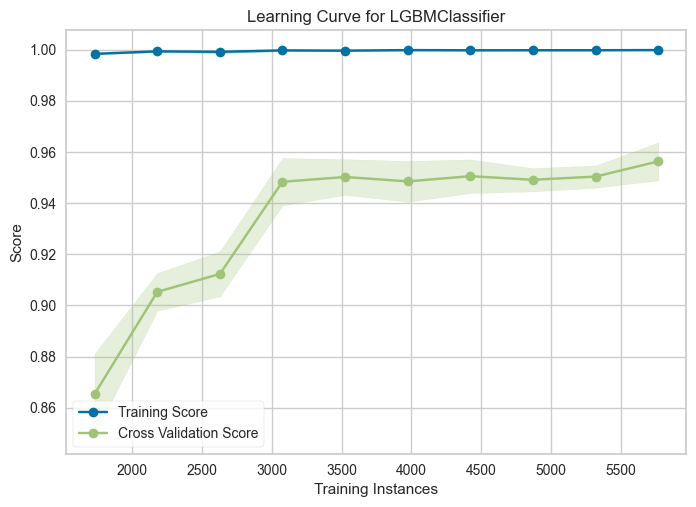

In [73]:
plot_model(model, plot='learning')

In [74]:
save_model(model, 'lightgbm')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='winner',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                                 colsample_bytree=1.0, feature_fraction=0.7,
                                 importance_type='split', learning_rate=0.4,
                                 max_depth=-1, min_child_samples=86,
                                 min_child_weight=0